In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kuj12at0 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
dataset_dim = 2
num_rand_samples = 0
num_unif_samples = 16
num_samples = num_rand_samples+num_unif_samples
noise_size = 0.1

In [3]:
np.random.seed(1)
ts = np.random.normal(3*np.pi/2,np.pi/3,num_rand_samples)
ts = np.concatenate((ts,np.linspace(5 * np.pi/6, 13 * np.pi / 6, num_unif_samples)))
rs = (1+ noise_size * np.exp((-(ts-(3*np.pi/2))**2)/4) * np.random.normal(size=num_samples))
xs = np.cos(ts) * rs
ys = np.sin(ts) * rs
dataset = np.hstack((xs[:,np.newaxis],ys[:,np.newaxis]))

(-1.0695576345431113,
 1.1180036069003711,
 -1.1457625386048613,
 0.6067877141519675)

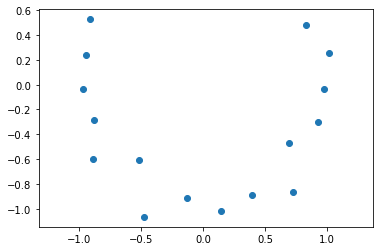

In [4]:
plt.scatter(dataset[:,0],dataset[:,1])
plt.axis("equal")
#plt.plot(np.cos(np.arange(0,100,0.01)),np.sin(np.arange(0,100,0.01)))

# 1D VAE Fit to Dataset

In [5]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device, alldata=False):
    """Sample Pair of Points from Trajectory"""
    if alldata:
        if batchsize is not None:
            raise "don't pass in batchsize if you're doing all data"
        traj_ids = range(all_points.shape[0])
        t1_ids = [0]
        t2_ids = t1_ids
    else:
        # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
        traj_ids = np.random.choice(all_points.shape[0], batchsize)
        t1_ids = np.random.choice(all_points.shape[1], batchsize)
        if predictive:
            t2_ids = np.random.choice(all_points.shape[1], batchsize)
        else:
            t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [6]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    

In [7]:
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [8]:
testname = "smlcirc/sml"

In [ ]:
all_models=[]
all_exceptions = []
for lr in [0.0001,0.00001]:
    for beta in [0.0001,0.01,0.1]:
        for curvreg in [0,0.1,0.01,0.2,0.5]:#,1,10,100,1000]:
            secreg = 0
            if curvreg != 0 and secreg != 0:
                continue
            for latentdim in [1]:
                for epsilon_scale_start in [0.5]:
                    try:
                        vae = make_vae(latent_dim=latentdim).to(device)
                        num_epochs = 1000
                        savedir  = f'{testname}_lr{lr}_lat{latentdim}_secreg{secreg}_curvreg{curvreg}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                        print(savedir)
                        trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                            log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.5)
                        epoch = 0
                        epsilon_scale = epsilon_scale_start
                        for _ in range(num_epochs*3):
                            epoch+=1
                            # had an off-by-one error here before
                            # update values BEFORE training 501st element
                            if epoch % num_epochs == 1 and epoch > 1: 
                                scheduler.step()
                            embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=128)
                            is_error = embst[0]
                            if is_error:
                                raise Exception
                        sm.save_fcpassthrough_vae(vae, savedir)
                        print(savedir)
                        all_models.append(savedir)
                    except:
                        print("error")

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0_beta0.0001_20220205-105834
smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0_beta0.0001_20220205-105834
smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.1_beta0.0001_20220205-110046
smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.1_beta0.0001_20220205-110046
smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.01_beta0.0001_20220205-110344
smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.01_beta0.0001_20220205-110344
smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.2_beta0.0001_20220205-110643


In [ ]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [ ]:

import importlib
importlib.reload(lm)

for i, modelpath in enumerate(all_models):
    print(modelpath)
    vae = lm.load_model(modelpath)

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0_beta0.0001_20220205-105834


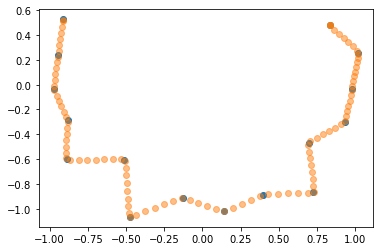

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.1_beta0.0001_20220205-110046


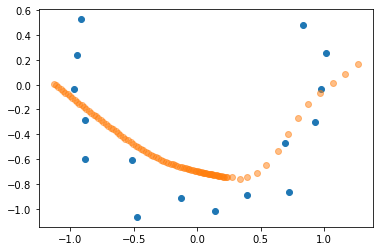

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.01_beta0.0001_20220205-110344


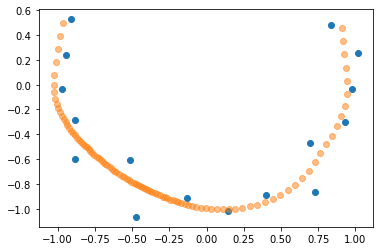

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.2_beta0.0001_20220205-110643


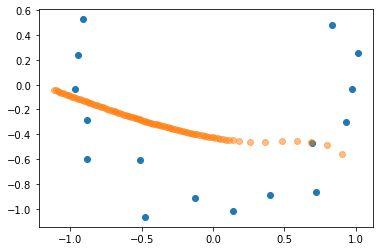

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.5_beta0.0001_20220205-110942


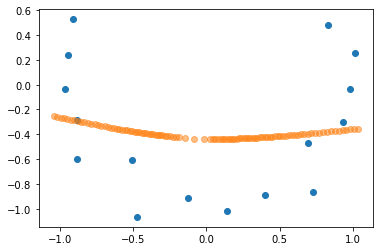

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0_beta0.01_20220205-111241


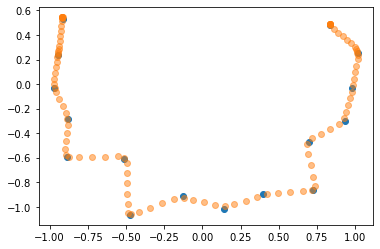

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.1_beta0.01_20220205-111451


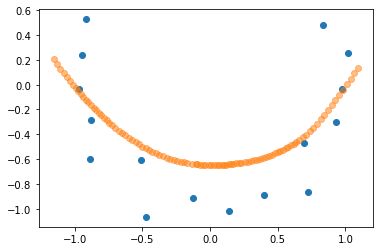

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.01_beta0.01_20220205-111750


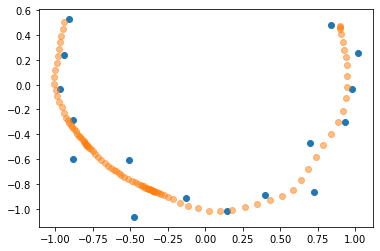

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.2_beta0.01_20220205-112050


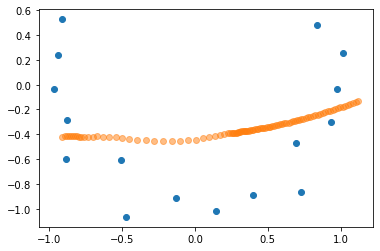

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.5_beta0.01_20220205-112349


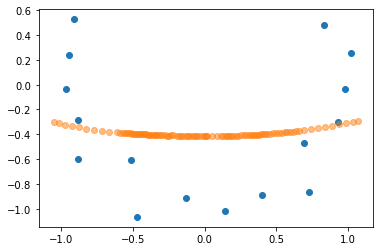

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0_beta0.1_20220205-112648


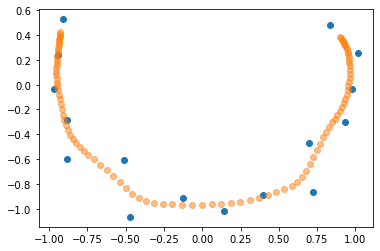

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.1_beta0.1_20220205-112858


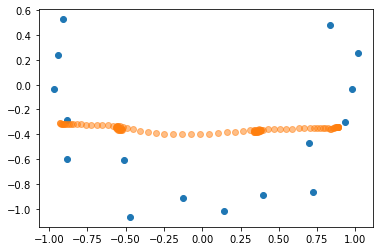

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.01_beta0.1_20220205-113158


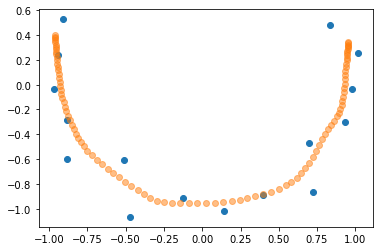

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.2_beta0.1_20220205-113457


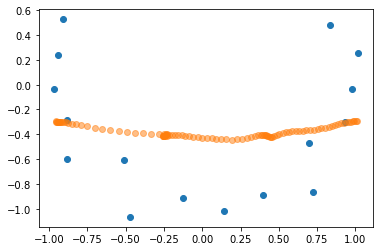

smlcirc/sml_lr0.0001_lat1_secreg0_curvreg0.5_beta0.1_20220205-113757


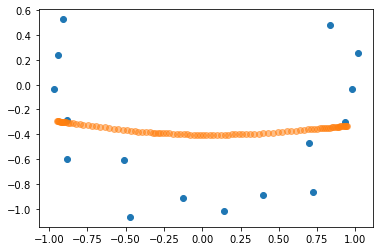

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0_beta0.0001_20220205-114056


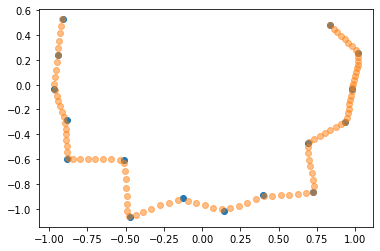

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.1_beta0.0001_20220205-114306


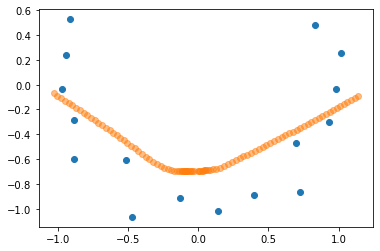

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.01_beta0.0001_20220205-114605


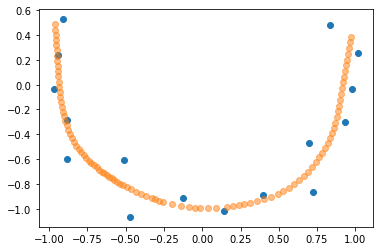

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.2_beta0.0001_20220205-114904


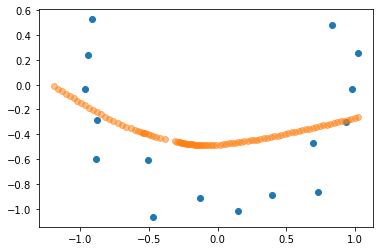

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.5_beta0.0001_20220205-115204


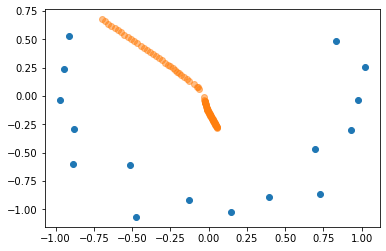

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0_beta0.01_20220205-115503


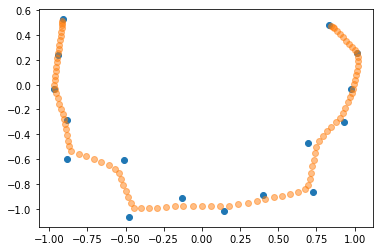

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.1_beta0.01_20220205-115713


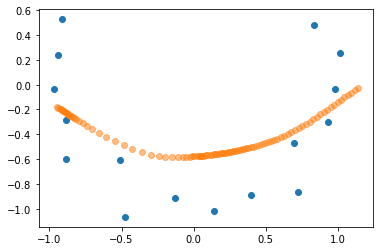

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.01_beta0.01_20220205-120011


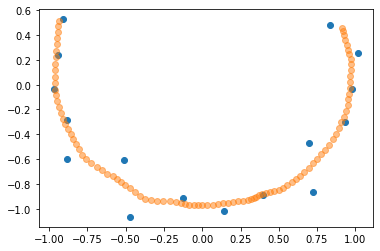

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.2_beta0.01_20220205-120311


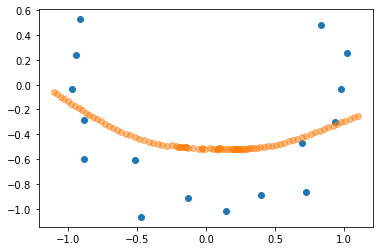

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.5_beta0.01_20220205-120609


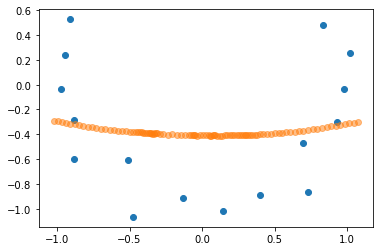

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0_beta0.1_20220205-120909


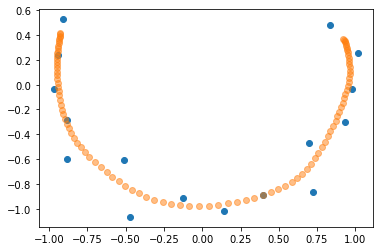

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.1_beta0.1_20220205-121119


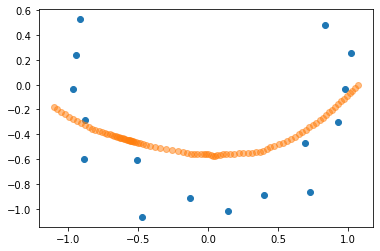

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.01_beta0.1_20220205-121418


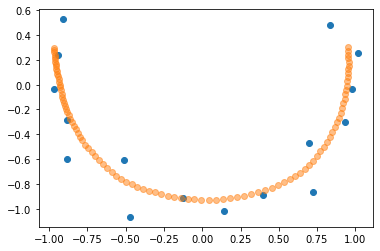

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.2_beta0.1_20220205-121717


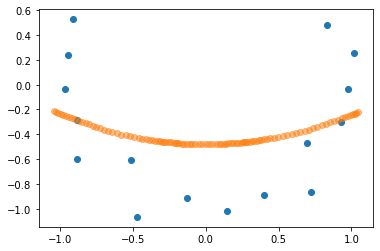

smlcirc/sml_lr1e-05_lat1_secreg0_curvreg0.5_beta0.1_20220205-122016


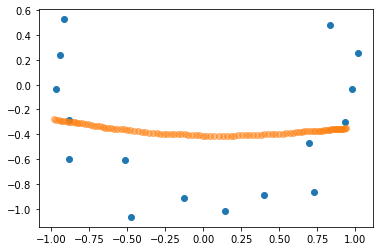

In [13]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = np.linspace(np.min(embeds[:,0]),np.max(embeds[:,0]),100).reshape((-1,1))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    plt.scatter(dataset[:,0],dataset[:,1]);
    plt.scatter(readout[:,0],readout[:,1], alpha=0.5);
    plt.show();plt.close()